In [74]:
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas_datareader
import datetime
import pandas as pd
from statsmodels.tsa.stattools import adfuller

In [75]:
print(tf.__version__)
print(tf.config.list_physical_devices())

2.13.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [76]:
pre_days = 5
mem_his_days = 20
epoch = 50

In [77]:
start = datetime.datetime(2000, 1, 3)
end = datetime.datetime(2023, 7, 7)

df = pandas_datareader.data.DataReader('NVDA', 'stooq', start, end)
df.sort_index(inplace=True)
df = df.fillna(method='pad')

df = df.drop('Open', axis=1)
df = df.drop('High', axis=1)
df = df.drop('Low', axis=1)
df = df.drop('Volume', axis=1)
print(df)

                 Close
Date                  
2000-01-03    0.894816
2000-01-04    0.871934
2000-01-05    0.842157
2000-01-06    0.787099
2000-01-07    0.800788
...                ...
2023-06-30  423.020000
2023-07-03  424.130000
2023-07-05  423.170000
2023-07-06  421.030000
2023-07-07  425.030000

[5915 rows x 1 columns]


In [78]:
print(df.head(10))
print(df.tail(10))

               Close
Date                
2000-01-03  0.894816
2000-01-04  0.871934
2000-01-05  0.842157
2000-01-06  0.787099
2000-01-07  0.800788
2000-01-10  0.826068
2000-01-11  0.793893
2000-01-12  0.773308
2000-01-13  0.805385
2000-01-14  0.839757
             Close
Date              
2023-06-23  422.09
2023-06-26  406.32
2023-06-27  418.76
2023-06-28  411.17
2023-06-29  408.22
2023-06-30  423.02
2023-07-03  424.13
2023-07-05  423.17
2023-07-06  421.03
2023-07-07  425.03


In [79]:
ts = df['Close']
print(ts)

def test_stationarity(timeseries):
    
    # Determing rolling statistics
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

    # Plot rolling statistics
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['adf','pvalue','usedlag', 'nobs'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


Date
2000-01-03      0.894816
2000-01-04      0.871934
2000-01-05      0.842157
2000-01-06      0.787099
2000-01-07      0.800788
                 ...    
2023-06-30    423.020000
2023-07-03    424.130000
2023-07-05    423.170000
2023-07-06    421.030000
2023-07-07    425.030000
Name: Close, Length: 5915, dtype: float64


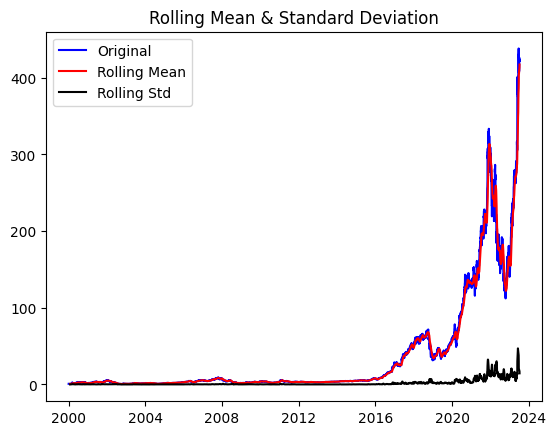

Results of Dickey-Fuller Test:
adf                        3.270114
pvalue                     1.000000
usedlag                   30.000000
nobs                    5884.000000
Critical Value (1%)       -3.431462
Critical Value (5%)       -2.862031
Critical Value (10%)      -2.567032
dtype: float64


In [80]:
test_stationarity(ts)

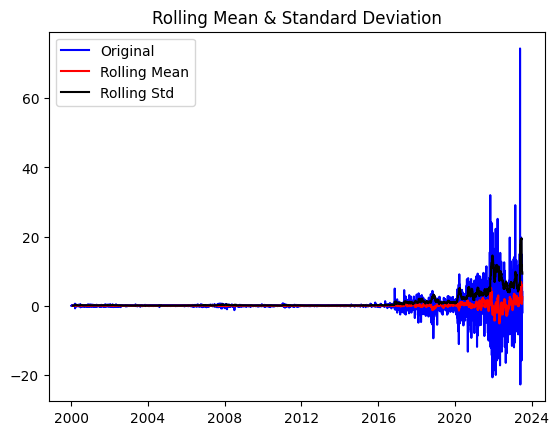

Results of Dickey-Fuller Test:
adf                    -1.305334e+01
pvalue                  2.119636e-24
usedlag                 2.900000e+01
nobs                    5.884000e+03
Critical Value (1%)    -3.431462e+00
Critical Value (5%)    -2.862031e+00
Critical Value (10%)   -2.567032e+00
dtype: float64


In [81]:
ts1= ts.diff().dropna() #一阶差分再进行ADF检验
test_stationarity(ts1)

In [82]:
Close = df['Close']
Close = Close.fillna(method='pad')
Close = Close.dropna()

df['DissClose'] = df[['Close']].diff().dropna()
df['Label'] = df['Close'].shift(-pre_days)
df = df.drop('Close', axis=1)
df = df.fillna(method='pad')
df = df.dropna()
print(df.head(10))
print(df.tail(10))

            DissClose     Label
Date                           
2000-01-04  -0.022882  0.793893
2000-01-05  -0.029777  0.773308
2000-01-06  -0.055058  0.805385
2000-01-07   0.013689  0.839757
2000-01-10   0.025280  0.876530
2000-01-11  -0.032175  0.867337
2000-01-12  -0.020585  0.865039
2000-01-13   0.032077  0.855846
2000-01-14   0.034372  0.816975
2000-01-18   0.036773  0.809981
            DissClose   Label
Date                         
2023-06-23      -8.16  423.02
2023-06-26     -15.77  424.13
2023-06-27      12.44  423.17
2023-06-28      -7.59  421.03
2023-06-29      -2.95  425.03
2023-06-30      14.80  425.03
2023-07-03       1.11  425.03
2023-07-05      -0.96  425.03
2023-07-06      -2.14  425.03
2023-07-07       4.00  425.03


In [83]:
# scaler = StandardScaler()

sca_x = df.to_numpy()
print(sca_x)

[[-2.28820e-02  7.93893e-01]
 [-2.97770e-02  7.73308e-01]
 [-5.50580e-02  8.05385e-01]
 ...
 [-9.60000e-01  4.25030e+02]
 [-2.14000e+00  4.25030e+02]
 [ 4.00000e+00  4.25030e+02]]


In [84]:
deq = collections.deque()

x = []
for row in sca_x:
    deq.append(list(row[:-1]))
    if len(deq) > mem_his_days:
        deq.popleft()
    if len(deq) == mem_his_days:
        x.append(list(deq))

y = df['Label'].values[mem_his_days - 1 :]
x, y = np.array(x), np.array(y)
print(len(x))
print(len(y))

5895
5895


In [85]:
total_num = len(x)
train_num = int(total_num * 0.99)

x_train, y_train = x[:train_num], y[:train_num]
x_test, y_test = x[train_num:-pre_days], y[train_num:-pre_days]
x_future, y_future = x[-pre_days:], y[-pre_days:]

batch_size = 128

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.repeat().shuffle(train_num).batch(batch_size=batch_size).prefetch(tf.data.experimental.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.shuffle(total_num - train_num).batch(batch_size=batch_size).prefetch(tf.data.experimental.AUTOTUNE)

sample = next(iter(train_ds))
print('x_train.shape:', sample[0].shape)
print('y_train.shape:', sample[1].shape)

x_train.shape: (128, 20, 1)
y_train.shape: (128,)


In [86]:
input_shape = sample[0].shape[-2:]

inputs = tf.keras.Input(shape=input_shape)

x = tf.keras.layers.GRU(8, activation='relu', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.GRU(8, activation='relu', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.GRU(16, activation='relu', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.GRU(32, activation='relu', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.GRU(32, activation='relu', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.GRU(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 20, 1)]           0         
                                                                 
 gru_11 (GRU)                (None, 20, 16)            912       
                                                                 
 dropout_19 (Dropout)        (None, 20, 16)            0         
                                                                 
 gru_12 (GRU)                (None, 20, 32)            4800      
                                                                 
 dropout_20 (Dropout)        (None, 20, 32)            0         
                                                                 
 gru_13 (GRU)                (None, 20, 32)            6336      
                                                                 
 dropout_21 (Dropout)        (None, 20, 32)            0   

In [87]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=tf.keras.losses.MeanSquaredLogarithmicError())

def lr_schedule(epoch):
    if epoch > 10:
        return 0.0005
    if epoch > 15:
        return 0.0002
    if epoch > 30:
        return 0.0001
    return 0.001
        
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule,verbose=True)

history = model.fit(train_ds,
                    steps_per_epoch=train_num / batch_size,
                    epochs=epoch,
                    callbacks=[lr_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/50
45/45 [==============================] - 5s 19ms/step - loss: 3305.7092 - mean_squared_logarithmic_error: 4.7689 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/50
45/45 [==============================] - 1s 21ms/step - loss: 1541.1440 - mean_squared_logarithmic_error: 1.3311 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/50
45/45 [==============================] - 1s 19ms/step - loss: 710.2767 - mean_squared_logarithmic_error: 0.5627 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/50
45/45 [==============================] - 1s 19ms/step - loss: 601.5761 - mean_squared_logarithmic_error: 0.3742 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/50
45/45 [==============================] - 1s 19ms/step - loss: 635.7494 - mean_squared_logarithmic_error: 0.3447 - lr: 0.001

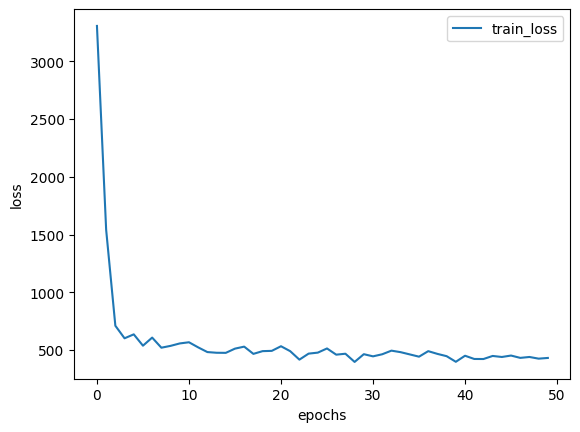

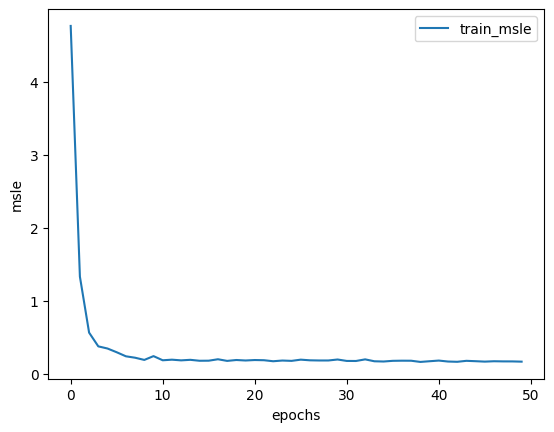

In [88]:
history_dict = history.history
train_loss = history_dict['loss']
train_msle = history_dict['mean_squared_logarithmic_error']

plt.figure()
plt.plot(range(epoch), train_loss, label='train_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

plt.figure()
plt.plot(range(epoch), train_msle, label='train_msle')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('msle')
plt.show()

183/183 [==============================] - 1s 4ms/step
(5836,)
(5836,)


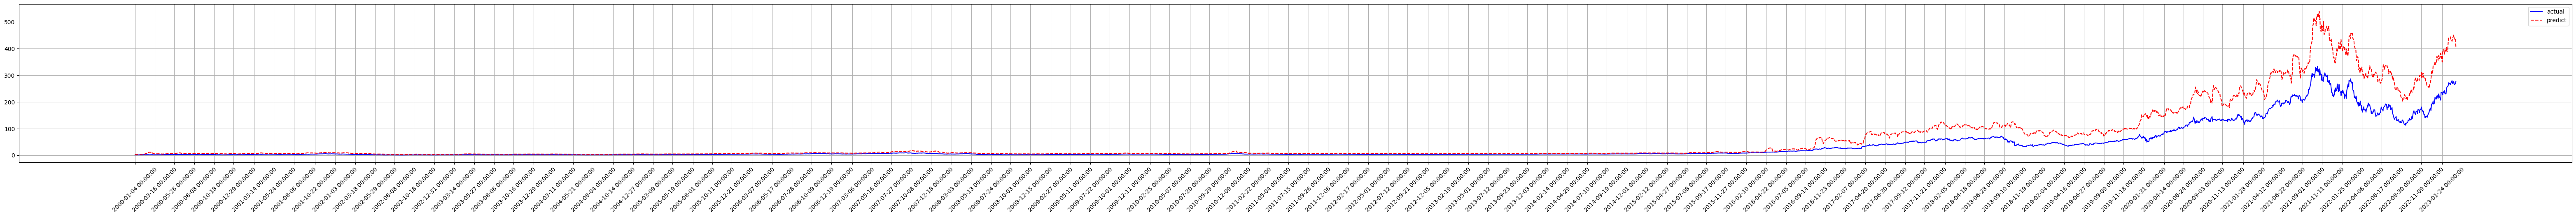

In [89]:
y_pred = model.predict(x_train)

df_time = df.index[:len(x_train)]

fig = plt.figure(figsize=(80, 5))
axes = fig.add_subplot(111)

y_pred = y_pred.reshape(-1)

print(y_train.shape)
print(y_pred.shape)

y_train_new = Close[mem_his_days  + pre_days - 1: mem_his_days + pre_days + train_num - 1]
y_pred_new = y_pred + Close[mem_his_days : train_num + mem_his_days]
axes.plot(df_time, y_train_new, 'b-', label='actual')
axes.plot(df_time, y_pred_new, 'r--', label='predict')

axes.set_xticks(df_time[::50])
axes.set_xticklabels(df_time[::50],rotation=45)

plt.legend()
plt.grid()
plt.show()

2/2 [==============================] - 0s 6ms/step
(54,)
(54,)
(54,)
5915
5909
5914


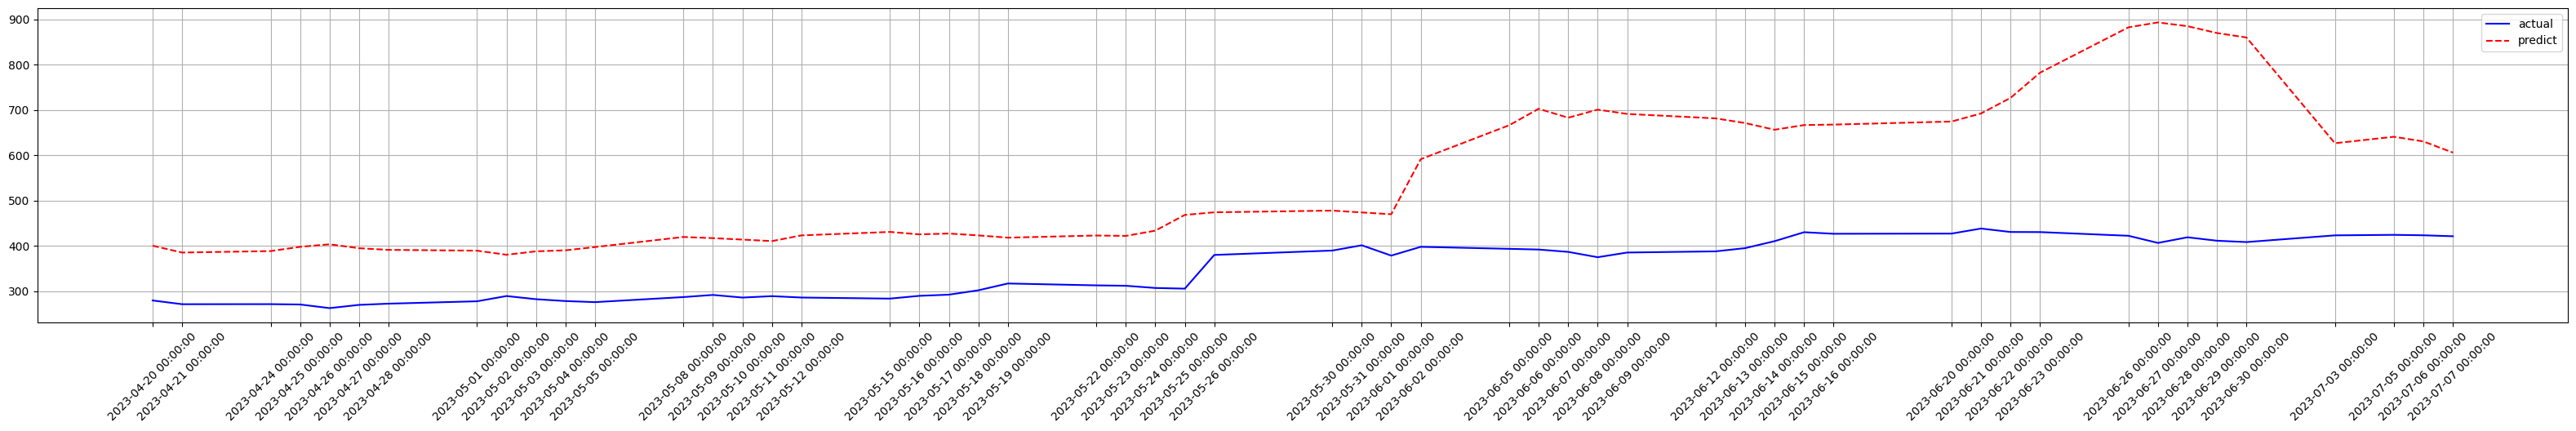

In [90]:
y_pred = model.predict(x_test)

df_time = df.index[-len(x_test):]

fig = plt.figure(figsize=(40, 5))
axes = fig.add_subplot(111)

y_pred = y_pred.reshape(-1)

print(y_test.shape)
print(y_pred.shape)
print(Close[-len(y_test) - mem_his_days - pre_days: - mem_his_days - pre_days].shape)
y_test_new = Close[mem_his_days + pre_days + train_num - 1 : mem_his_days + pre_days + train_num - 1 + len(y_test)]
y_pred_new = y_pred + Close[train_num + mem_his_days : train_num + mem_his_days + len(y_test)]
axes.plot(df_time, y_test_new, 'b-', label='actual')
axes.plot(df_time, y_pred_new, 'r--', label='predict')
print(len(Close))
print(train_num + mem_his_days - 1 + len(y_test))
print(mem_his_days + pre_days + train_num - 1 + len(y_test))

axes.set_xticks(df_time[::1])
axes.set_xticklabels(df_time[::1],rotation=45)

plt.legend()
plt.grid()
plt.show()

1/1 [==============================] - 0s 24ms/step
(5,)
(5,)


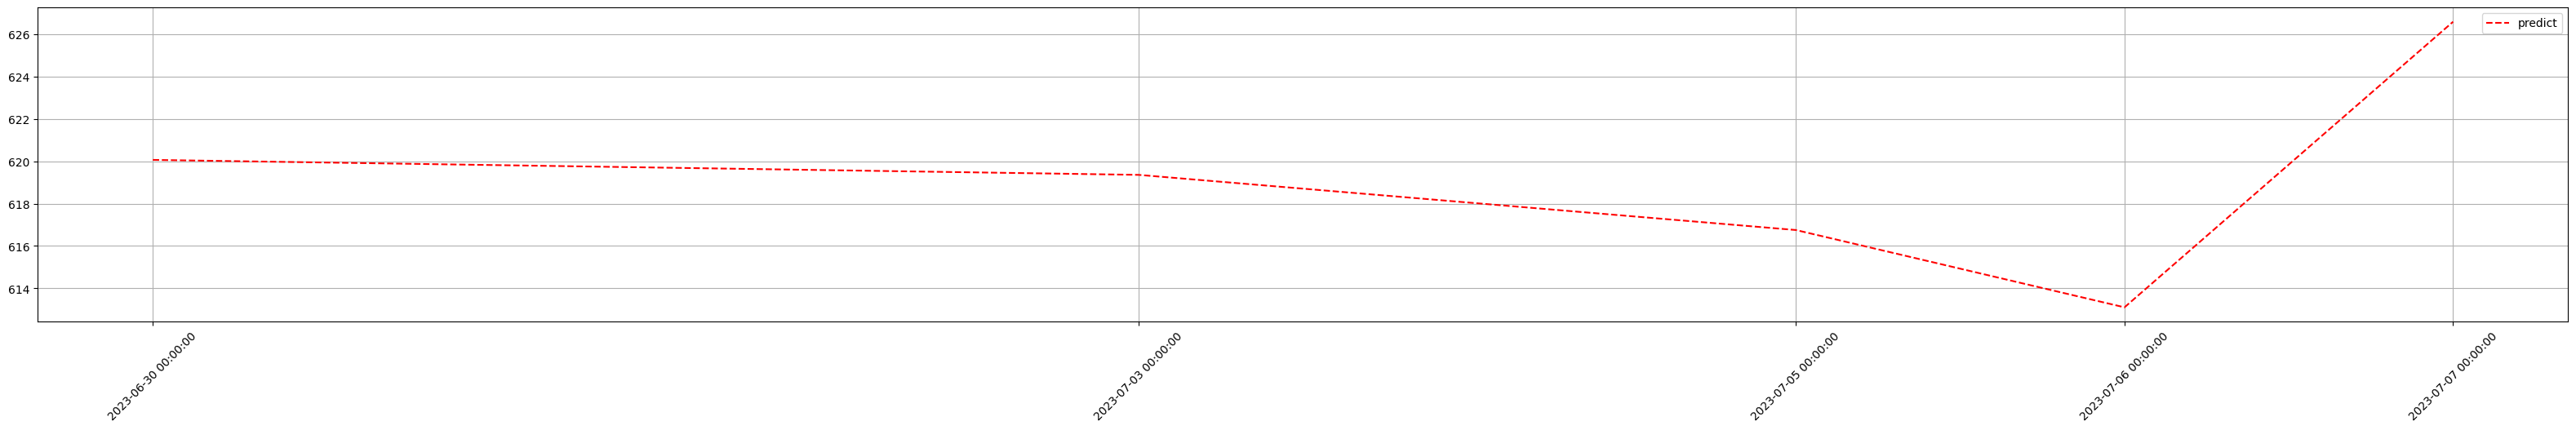

In [91]:
y_pred = model.predict(x_future)

df_time = df.index[-pre_days:]

fig = plt.figure(figsize=(40, 5))
axes = fig.add_subplot(111)

y_pred = y_pred.reshape(-1)

print(y_pred.shape)
print(Close[-pre_days:].shape)

y_pred_new = y_pred + Close[-pre_days:]
axes.plot(df_time, y_pred_new, 'r--', label='predict')

axes.set_xticks(df_time[::1])
axes.set_xticklabels(df_time[::1],rotation=45)

plt.legend()
plt.grid()
plt.show()